# Multi-Factor Investing 
Fama and French 5 Faktor Model

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
from datetime import datetime, timedelta
warnings.simplefilter(action='ignore',category=FutureWarning)

### 1) Data Import

##### 1.1) ETF data

In [2]:
# Define URLs for different categories
URLs = {
    'MA': "https://finance.yahoo.com/markets/etfs/most-active/",
    'TN': "https://finance.yahoo.com/markets/etfs/top-performing/",
    'GA': "https://finance.yahoo.com/markets/etfs/gainers/",
    'TP': "https://finance.yahoo.com/markets/etfs/losers/",
    'TN': "https://finance.yahoo.com/markets/etfs/trending/",
    'BH': "https://finance.yahoo.com/markets/etfs/best-historical-performance/",
}

def fetch_and_parse_ticker(url):
    page = requests.get(url).content
    tree = etree.HTML(page)
    nodes = tree.xpath("//*[contains(concat(' ', @class, ' '), concat(' ', 'yf-138ga19', ' '))]")
    texts = [node.text for node in nodes]
    cleaned = [text.strip() for text in texts if text and text.strip()]
    tickers = [cleaned[i] for i in range(0, len(cleaned), 2)]
    return tickers

def create_table_if_not_exists(conn):
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS etf_categories
    (date TEXT, ticker TEXT, category TEXT, timestamp TEXT)
    ''')
    conn.commit()

def data_exists_for_today(conn, date):
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM etf_categories WHERE date = ?", (date,))
    count = cursor.fetchone()[0]
    return count > 0

def main():
    current_date = dt.date.today().isoformat()
    db_path = os.path.join(os.getcwd(), 'etf_data.db')

    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)

    # Create table if it doesn't exist
    create_table_if_not_exists(conn)

    # Check if data for today already exists
    if data_exists_for_today(conn, current_date):
        print(f"Data for {current_date} already exists. Skipping insertion.")
        conn.close()
        return

    # Fetch and parse data for each category
    data = {category: fetch_and_parse_ticker(url) for category, url in URLs.items()}

    # Create a set of all unique tickers
    all_tickers = set()
    for tickers in data.values():
        all_tickers.update(tickers)

    # Create a DataFrame with all tickers and categories
    df = pd.DataFrame(index=sorted(all_tickers), columns=URLs.keys())

    # Fill the DataFrame
    for category, tickers in data.items():
        df[category] = df.index.isin(tickers).astype(int)

    # Reset index to make 'ticker' a column
    df = df.reset_index().rename(columns={'index': 'ticker'})

    # Display the first few rows of the DataFrame
    print(df.head())

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(os.getcwd(), 'etf_categories.csv')
    df.to_csv(csv_path, index=False)
    print(f"Data saved to {csv_path}")

    # Prepare data for insertion
    data_to_insert = []
    current_timestamp = dt.datetime.now().isoformat()
    for category, tickers in data.items():
        for ticker in tickers:
            data_to_insert.append((current_date, ticker, category, current_timestamp))

    # Insert data into database
    cursor = conn.cursor()
    query = '''
    INSERT INTO etf_categories (date, ticker, category, timestamp)
    VALUES (?, ?, ?, ?)
    '''
    cursor.executemany(query, data_to_insert)
    conn.commit()

    # Close the cursor and connection
    cursor.close()
    conn.close()

    print(f"Data inserted successfully into {db_path}")

    # Check content of database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Execute the SQL query
    query = """
    SELECT DISTINCT ticker
    FROM etf_categories
    WHERE date = ?
      AND category = 'MA'
    ORDER BY ticker;
    """
    cursor.execute(query, (current_date,))

    # Fetch and print the results
    results = cursor.fetchall()
    print(f"\nTickers in the 'MA' category for {current_date}:")
    for row in results:
        print(row[0])

if __name__ == "__main__":
    main()

Empty DataFrame
Columns: [ticker, MA, TN, GA, TP, BH]
Index: []
Data saved to c:\Users\lkreisel\workspace\uni-projects\advanced_topics_in_asset_management\etf_categories.csv
Data inserted successfully into c:\Users\lkreisel\workspace\uni-projects\advanced_topics_in_asset_management\etf_data.db

Tickers in the 'MA' category for 2024-11-02:


In [3]:
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT DISTINCT ticker FROM etf_categories")
tickers = cursor.fetchall()

def table_exists(ticker):
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name=?", (ticker,))
    return cursor.fetchone() is not None

def create_and_populate_table(ticker):
    if table_exists(ticker):
        print(f"Table for {ticker} already exists. Skipping creation.")
        return

    # Create the table if it doesn't exist
    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS "{ticker}" (
        Date TEXT PRIMARY KEY,
        Open REAL,
        High REAL,
        Low REAL,
        Close REAL,
        Volume INTEGER,
        Dividends REAL,
        Stock_Splits REAL
    )
    ''')
    conn.commit()

    # Calculate date range for the past year
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=365)

    # Fetch historical data
    stock = yf.Ticker(ticker)
    hist = stock.history(period="max")

    # Convert the index to datetime.date objects
    hist.index = hist.index.date

    # Create a dictionary to hold the data
    data_dict = {date: None for date in (start_date + timedelta(n) for n in range((end_date - start_date).days + 1))}

    # Update the dictionary with actual data
    for date, row in hist.iterrows():
        data_dict[date] = row

    # Insert data into the table
    for date in data_dict:
        date_str = date.strftime('%Y-%m-%d')
        if data_dict[date] is not None:
            row = data_dict[date]
            cursor.execute(f'''
            INSERT OR REPLACE INTO "{ticker}" (Date, Open, High, Low, Close, Volume, Dividends, Stock_Splits)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (date_str, row['Open'], row['High'], row['Low'], row['Close'], 
                  row['Volume'], row['Dividends'], row['Stock Splits']))
        else:
            cursor.execute(f'''
            INSERT OR REPLACE INTO "{ticker}" (Date, Open, High, Low, Close, Volume, Dividends, Stock_Splits)
            VALUES (?, 0, 0, 0, 0, 0, 0, 0)
            ''', (date_str,))

    conn.commit()

    print(f"Historical data for {ticker} has been inserted into the database.")

    # Verify the data insertion
    cursor.execute(f'SELECT COUNT(*) FROM "{ticker}"')
    row_count = cursor.fetchone()[0]
    print(f"Number of rows in {ticker} table: {row_count}")

In [4]:
# Iterate over each ticker to create tables and insert data
for ticker in tickers:
    specific_ticker = ticker[0]  # Extract the ticker from the tuple
    try:
        create_and_populate_table(specific_ticker)
    except Exception as e:
        print(f"Error processing {specific_ticker}: {str(e)}")

Table for SQQQ already exists. Skipping creation.
Table for TSLL already exists. Skipping creation.
Table for SOXL already exists. Skipping creation.
Table for SOXS already exists. Skipping creation.
Table for TQQQ already exists. Skipping creation.
Table for IBIT already exists. Skipping creation.
Table for SPY already exists. Skipping creation.
Table for SPXS already exists. Skipping creation.
Table for QQQ already exists. Skipping creation.
Table for NVDQ already exists. Skipping creation.
Table for HYG already exists. Skipping creation.
Table for SH already exists. Skipping creation.
Table for UVIX already exists. Skipping creation.
Table for FXI already exists. Skipping creation.
Table for TLT already exists. Skipping creation.
Table for YANG already exists. Skipping creation.
Table for XLF already exists. Skipping creation.
Table for IWM already exists. Skipping creation.
Table for TECS already exists. Skipping creation.
Table for DUST already exists. Skipping creation.
Table for

In [5]:
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('''
SELECT Date, Open, High, Low, Close, Volume
FROM "SQQQ"
ORDER BY Date DESC
LIMIT 10
''')

# Fetch the results
results = cursor.fetchall()

# Print column names
print("Date\t\tOpen\tHigh\tLow\tClose\tVolume")
print("-" * 60)

# Print the first 10 rows
for row in results:
    print(f"{row[0]}\t{row[1]:.2f}\t{row[2]:.2f}\t{row[3]:.2f}\t{row[4]:.2f}\t{row[5]}")

Date		Open	High	Low	Close	Volume
------------------------------------------------------------
2024-08-30 00:00:00	8.11	8.34	8.00	8.04	152042900
2024-08-29 00:00:00	8.19	8.38	7.93	8.31	197741300
2024-08-28 00:00:00	8.03	8.45	7.99	8.28	156423900
2024-08-27 00:00:00	8.16	8.26	7.94	7.99	112840900
2024-08-26 00:00:00	7.86	8.17	7.81	8.07	132504700
2024-08-23 00:00:00	7.88	8.08	7.69	7.82	186301400
2024-08-22 00:00:00	7.61	8.14	7.58	8.08	195041900
2024-08-21 00:00:00	7.79	7.87	7.62	7.71	129626900
2024-08-20 00:00:00	7.81	7.90	7.69	7.83	140721700
2024-08-19 00:00:00	8.08	8.18	7.77	7.78	129185900


##### 1.2) Fama and French 5-factor data
1-year time window (starting from 2023-10-28)

In [6]:
# Read the CSV file, skipping the first two rows of metadata
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2023-10-28
ff5 = ff5[ff5.index >= '2023-10-28']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     

# Drop index
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

# Save the filtered data to a new CSV file (uncomment if needed)
# ff5.to_csv('filtered_fama_french_data.csv')

        Date  Mkt-RF   SMB   HML   RMW   CMA     RF
0 2023-10-30    1.15 -0.33  0.28 -0.15  0.17  0.021
1 2023-10-31    0.63  0.05 -0.07 -0.85  0.06  0.021
2 2023-11-01    0.93 -0.68 -0.02  0.12 -0.71  0.021
3 2023-11-02    1.95  0.71  1.64 -0.23  0.53  0.021
4 2023-11-03    1.10  1.73  0.60 -1.19  0.18  0.021


### 2) Data Analysis
(Limited on the first 5 ETFs that are available in the Database)

##### 2.1) Visualize ETF data 

Missing required price columns for etf_categories. Skipping.


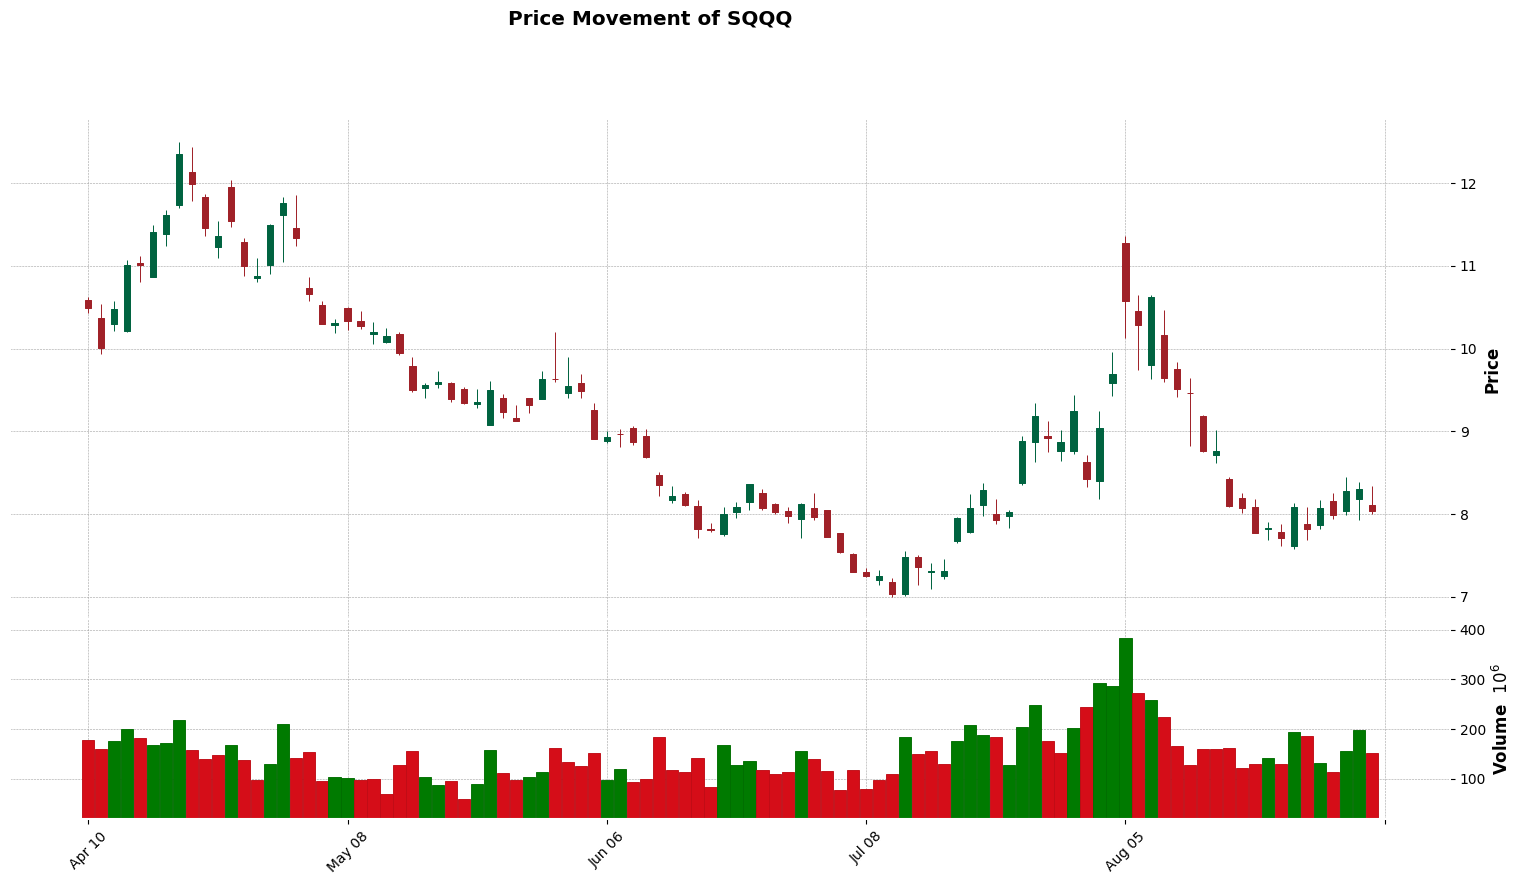

Chart created for SQQQ


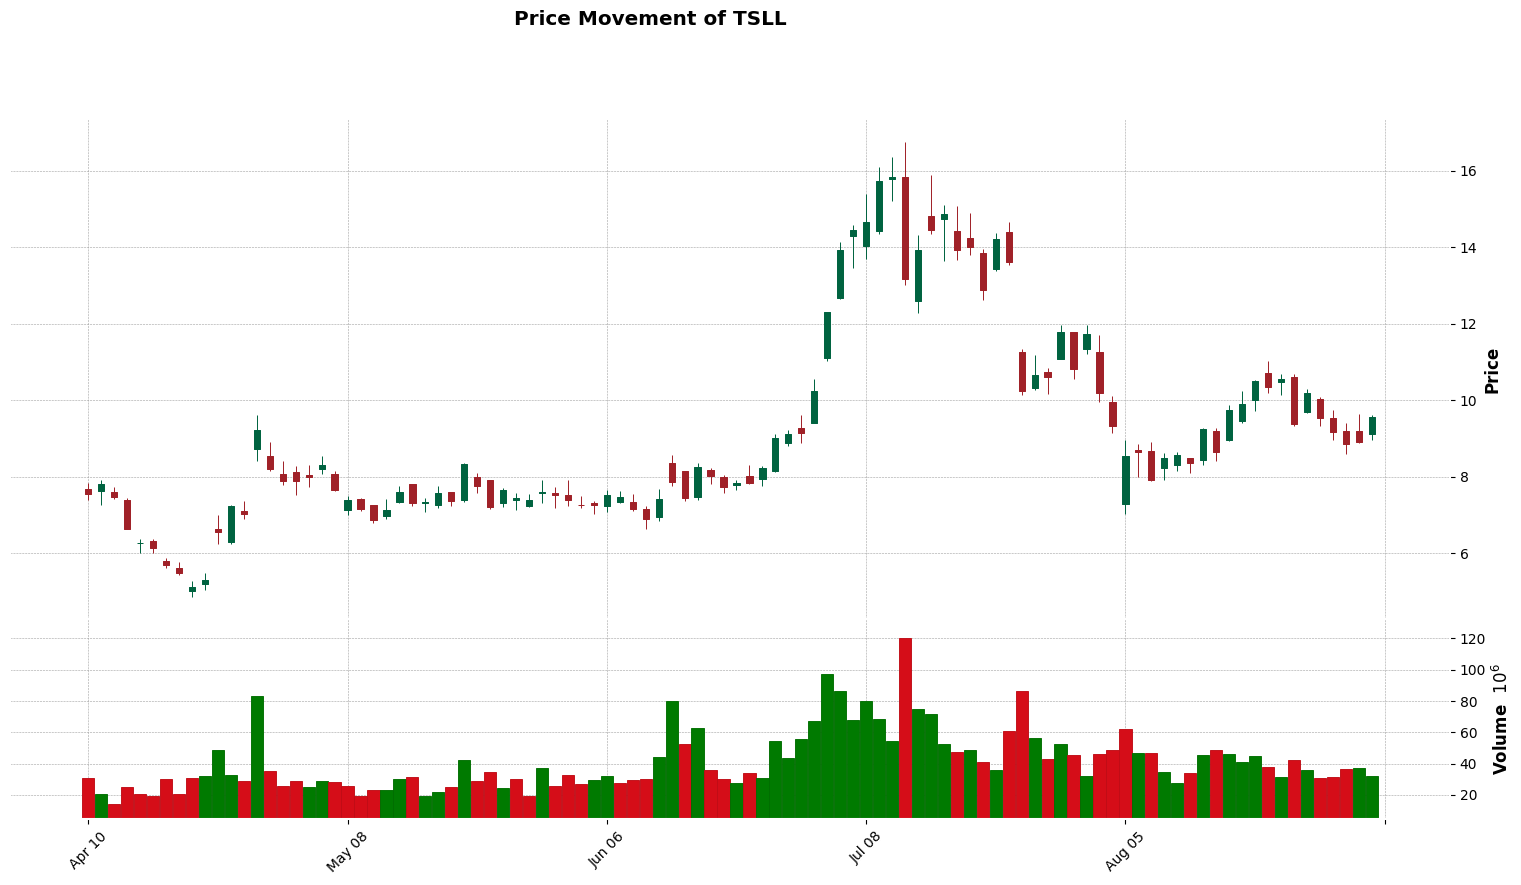

Chart created for TSLL


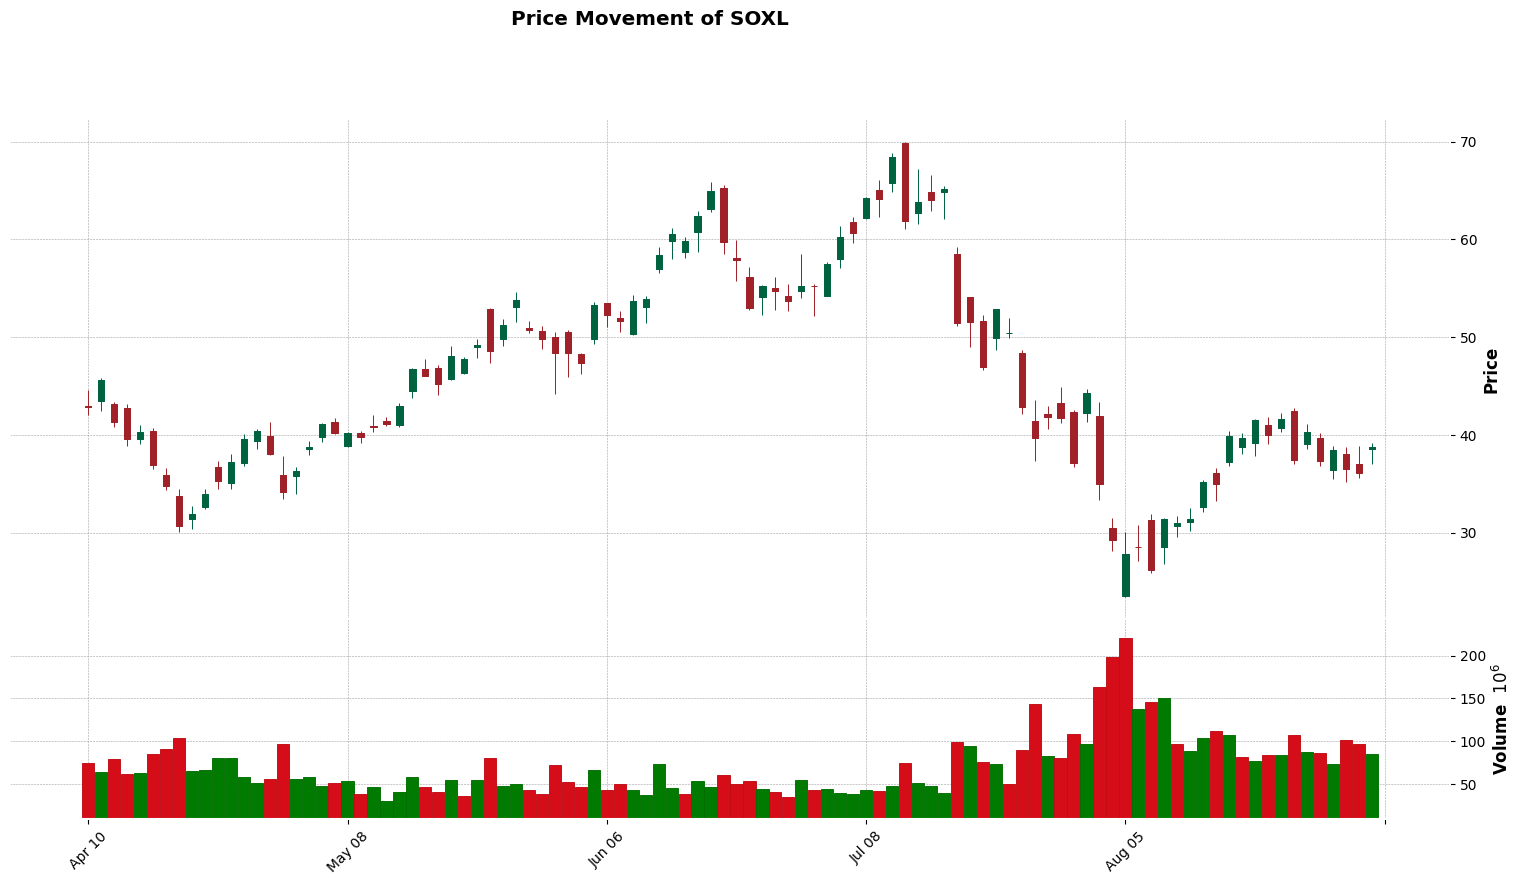

Chart created for SOXL


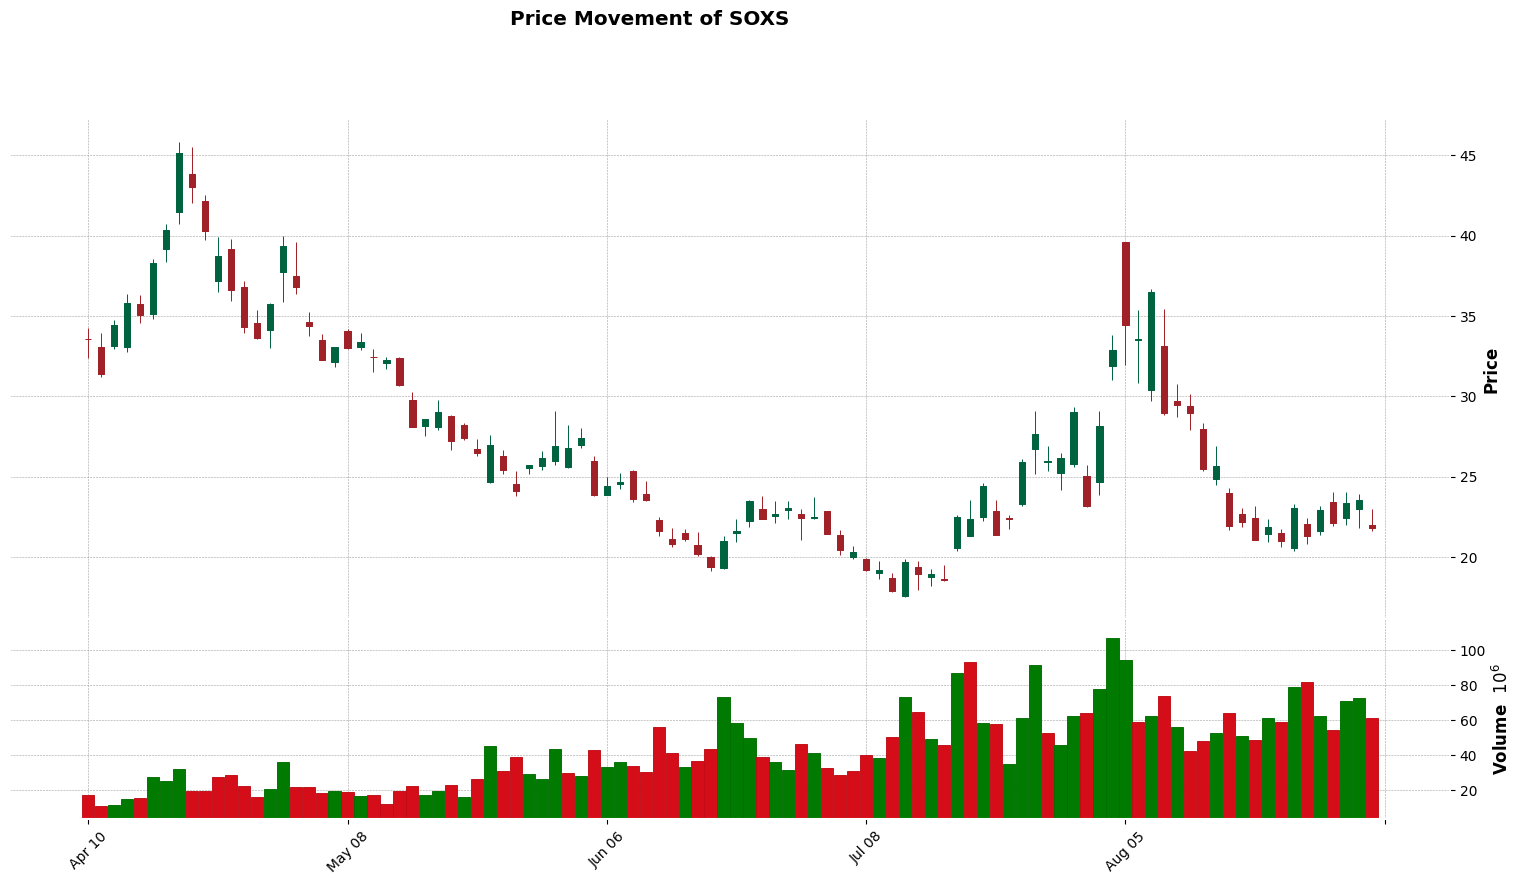

Chart created for SOXS
Candlestick charts creation process completed.


In [7]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get the first 5 tickers
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' LIMIT 5")
tickers = [ticker[0] for ticker in cursor.fetchall()]

# Function to get data for a ticker
def get_ticker_data(ticker):
    # First, let's check the structure of the table
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({ticker})")
    columns = [col[1] for col in cursor.fetchall()]
    
    # Construct the SQL query based on available columns
    date_col = 'Date' if 'Date' in columns else 'date'
    price_cols = [col for col in ['Open', 'High', 'Low', 'Close'] if col in columns]
    volume_col = 'Volume' if 'Volume' in columns else None
    
    select_cols = [date_col] + price_cols + ([volume_col] if volume_col else [])
    select_cols_str = ', '.join(select_cols)
    
    sql_query = f'''
    SELECT {select_cols_str}
    FROM {ticker}
    ORDER BY {date_col} DESC
    LIMIT 100
    '''
    
    df = pd.read_sql_query(sql_query, conn)
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    
    # Rename columns if necessary
    column_map = {'opening_price_cer': 'Open', 'daily_high_cer': 'High', 
                  'daily_low_cer': 'Low', 'closing_price_cer': 'Close'}
    df.rename(columns=column_map, inplace=True)
    
    return df.sort_index()

# Create plots for each ticker
for ticker in tickers:
    try:
        data = get_ticker_data(ticker)
        
        if len(data) == 0:
            print(f"No data available for {ticker}. Skipping.")
            continue
        
        if not all(col in data.columns for col in ['Open', 'High', 'Low', 'Close']):
            print(f"Missing required price columns for {ticker}. Skipping.")
            continue
        
        # Define figure size and scale
        figsize = (20, 10) 
        figscale = 1.5  

        # Plot candlestick chart
        mpf.plot(data, type='candle', style='charles', 
                 title=f'Price Movement of {ticker}', 
                 ylabel='Price', 
                 volume='Volume' in data.columns, 
                 figsize=figsize, 
                 figscale=figscale)
        
        # Save the plot as a PNG file
        plt.savefig(f'{ticker}_candlestick.png')
        plt.close()  # Close the plot to free up memory
        
        print(f"Chart created for {ticker}")
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

# Close the database connection
conn.close()

print("Candlestick charts creation process completed.")

##### 2.2) Computation of daily returns 

In [8]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get all tickers (tables) except 'etf_categories'
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories' LIMIT 5")
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories'")
tickers = [ticker[0] for ticker in cursor.fetchall()]

def calculate_and_store_daily_returns(ticker):
    try:
        # Check if the table has the necessary columns
        cursor.execute(f"PRAGMA table_info({ticker})")
        columns = [col[1] for col in cursor.fetchall()]
        if 'Date' not in columns or 'Close' not in columns:
            print(f"Skipping {ticker}: missing required columns")
            return

        # Fetch data
        query = f"SELECT Date, Close FROM {ticker} ORDER BY Date"
        df = pd.read_sql_query(query, conn)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Calculate daily returns
        df['Daily_Return'] = df['Close'].pct_change()
        
        # Replace infinity and NaN with NULL for SQL
        df['Daily_Return'] = df['Daily_Return'].replace([np.inf, -np.inf], np.nan)
        
        # Check if 'Daily_Return' column exists, if not, add it
        if 'Daily_Return' not in columns:
            cursor.execute(f"ALTER TABLE {ticker} ADD COLUMN Daily_Return REAL")
        
        # Update the table with daily returns
        for date, daily_return in df['Daily_Return'].items():
            if pd.notna(daily_return):
                cursor.execute(f"""
                    UPDATE {ticker}
                    SET Daily_Return = ?
                    WHERE Date = ?
                """, (float(daily_return), date.strftime('%Y-%m-%d')))
        
        conn.commit()
        print(f"Daily returns calculated and stored for {ticker}")
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

# Process each ticker
for ticker in tickers:
    calculate_and_store_daily_returns(ticker)

print("Daily returns have been calculated and stored for all applicable tickers.")

Daily returns calculated and stored for SQQQ
Daily returns calculated and stored for TSLL
Daily returns calculated and stored for SOXL
Daily returns calculated and stored for SOXS
Daily returns calculated and stored for TQQQ
Daily returns have been calculated and stored for all applicable tickers.


In [9]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Function to check columns in the dataframe for the given ticker
def check_columns(ticker):
    try:
        # Check if the table has the necessary columns
        cursor = conn.cursor()
        cursor.execute(f"PRAGMA table_info({ticker})")
        columns = [col[1] for col in cursor.fetchall()]
        
        print(f"Columns in {ticker}: {columns}")
        
        # Check if DataFrame has the required columns
        query = f"SELECT * FROM {ticker} LIMIT 1"
        df = pd.read_sql_query(query, conn)
        
        df_columns = df.columns.tolist()
        print(f"DataFrame columns for {ticker}: {df_columns}")
        
    except Exception as e:
        print(f"Error checking columns for {ticker}: {str(e)}")

# Specify the ticker to check
ticker = 'SQQQ'
check_columns(ticker)

Columns in SQQQ: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Daily_Return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
DataFrame columns for SQQQ: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Daily_Return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']


#### 2.3) Merge data of Fama and French with ETF datatables

In [10]:
# Add ff5 to the database
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Load ff5 into the SQLite database as a new table
ff5.to_sql('ff5', conn, if_exists='replace', index=False)

211

In [11]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get all tickers (tables) except 'etf_categories'
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories'")
tickers = [ticker[0] for ticker in cursor.fetchall()]

# Load ff5 data from the database (assuming it has been previously loaded)
ff5 = pd.read_sql_query("SELECT * FROM ff5", conn)
ff5['Date'] = pd.to_datetime(ff5['Date'])  # Ensure Date is in datetime format
ff5.set_index('Date', inplace=True)  # Set Date as index for merging

def merge_data_with_ff5(ticker):
    try:
        # Fetch ETF data
        query = f"SELECT * FROM {ticker}"
        df = pd.read_sql_query(query, conn)
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
        df.set_index('Date', inplace=True)  # Set Date as index for merging

        # Merge with ff5 data using inner join on Date
        merged_df = pd.merge(df, ff5, left_index=True, right_index=True, how='inner')

        # Update the table with merged data
        merged_df.reset_index(inplace=True)  # Reset index to include Date as a column
        merged_df.to_sql(ticker, conn, if_exists='replace', index=False)

        print(f"Successfully updated {ticker} with FF5 data.")
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Process each ticker
for ticker in tickers:
    merge_data_with_ff5(ticker)


Successfully updated SQQQ with FF5 data.
Successfully updated TSLL with FF5 data.
Successfully updated SOXL with FF5 data.
Successfully updated SOXS with FF5 data.
Successfully updated TQQQ with FF5 data.
Successfully updated IBIT with FF5 data.
Successfully updated SPY with FF5 data.
Successfully updated SPXS with FF5 data.
Successfully updated QQQ with FF5 data.
Successfully updated NVDQ with FF5 data.
Successfully updated HYG with FF5 data.
Successfully updated SH with FF5 data.
Successfully updated UVIX with FF5 data.
Successfully updated FXI with FF5 data.
Successfully updated TLT with FF5 data.
Successfully updated YANG with FF5 data.
Successfully updated XLF with FF5 data.
Successfully updated IWM with FF5 data.
Successfully updated TECS with FF5 data.
Successfully updated DUST with FF5 data.
Successfully updated GDX with FF5 data.
Successfully updated NVDL with FF5 data.
Successfully updated EEM with FF5 data.
Successfully updated NVD with FF5 data.
Successfully updated TZA wit

In [12]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Function to get column names from a specified table
def get_column_names(table_name):
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [column[1] for column in cursor.fetchall()]
    return columns

# Check columns in the SQQQ table
sqqq_columns = get_column_names('SQQQ')
print("Columns in SQQQ table:", sqqq_columns)

# Fetch first 5 observations from the SQQQ table
query = "SELECT * FROM SQQQ LIMIT 5"
first_five_rows = pd.read_sql_query(query, conn)
print("\nFirst 5 observations in SQQQ table:")
print(first_five_rows)

Columns in SQQQ table: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Daily_Return', 'Mkt-RF_x', 'SMB_x', 'HML_x', 'RMW_x', 'CMA_x', 'RF_x', 'Mkt-RF_y', 'SMB_y', 'HML_y', 'RMW_y', 'CMA_y', 'RF_y']

First 5 observations in SQQQ table:
                  Date       Open       High        Low      Close     Volume  \
0  2023-10-30 00:00:00  20.674293  20.934112  20.182489  20.442310  140844900   
1  2023-10-31 00:00:00  20.433031  20.896996  20.080416  20.136093  117189300   
2  2023-11-01 00:00:00  20.006183  20.024742  19.004018  19.087532  153221200   
3  2023-11-02 00:00:00  18.400862  18.595728  18.057526  18.094645  128955100   
4  2023-11-03 00:00:00  17.918337  17.946176  17.268787  17.463652  142282700   

   Dividends  Stock_Splits  Daily_Return  Mkt-RF_x  ...  HML_x  RMW_x  CMA_x  \
0        0.0           0.0           NaN      1.15  ...   0.28  -0.15   0.17   
1        0.0           0.0     -0.014980      0.63  ...  -0.07  -0.85   0.06   
2    

### 3) Set up and run Fama and French 5-Factor Model

In [18]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get all tickers (tables) except 'etf_categories'
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories'")
tickers = [ticker[0] for ticker in cursor.fetchall()][:5]  # Get first 5 tickers

def compute_excess_return_and_run_regression(ticker):
    try:
        # Fetch ETF data
        query = f"SELECT * FROM {ticker}"
        df = pd.read_sql_query(query, conn)
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
        df.set_index('Date', inplace=True)  # Set Date as index

        # Replace NaN values in Daily_Return with 0
        df['Daily_Return'].fillna(0, inplace=True)

        # Calculate excess returns: ETF returns - Risk-free rate
        df['Excess_Return'] = df['Daily_Return'] - df['RF_x']

        # Check for NaN values in relevant columns after calculation
        if df[['Excess_Return', 'Mkt-RF_x', 'SMB_x', 'HML_x', 'RMW_x', 'CMA_x']].isnull().any().any():
            print(f"NaN values found in {ticker} after calculation. Dropping rows with NaN values.")
            df.dropna(subset=['Excess_Return', 'Mkt-RF_x', 'SMB_x', 'HML_x', 'RMW_x', 'CMA_x'], inplace=True)

        # Prepare X and y for regression
        X = df[['Mkt-RF_x', 'SMB_x', 'HML_x', 'RMW_x', 'CMA_x']]
        y = df['Excess_Return']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print(f"Regression results for {ticker}:")
        print(model.summary())
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run computation and regression for each ticker
for ticker in tickers:
    compute_excess_return_and_run_regression(ticker)

Regression results for SQQQ:
                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           1.36e-63
Time:                        09:42:00   Log-Likelihood:                 598.15
No. Observations:                 211   AIC:                            -1184.
Df Residuals:                     205   BIC:                            -1164.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0200  

### 4) Robustness Check

4.1) HML

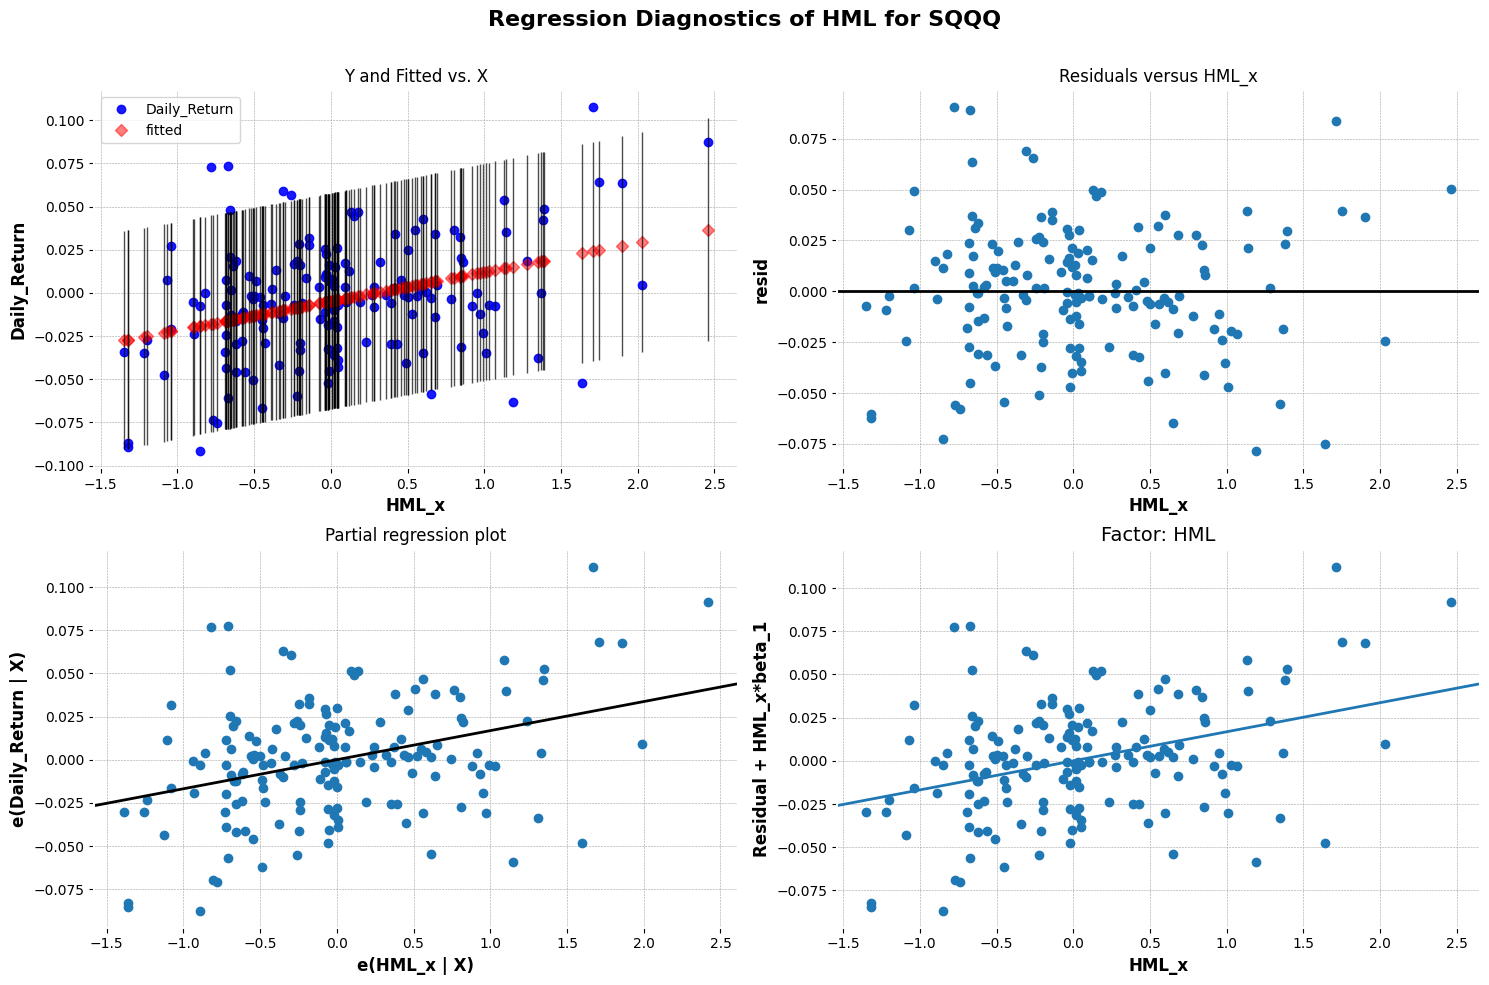

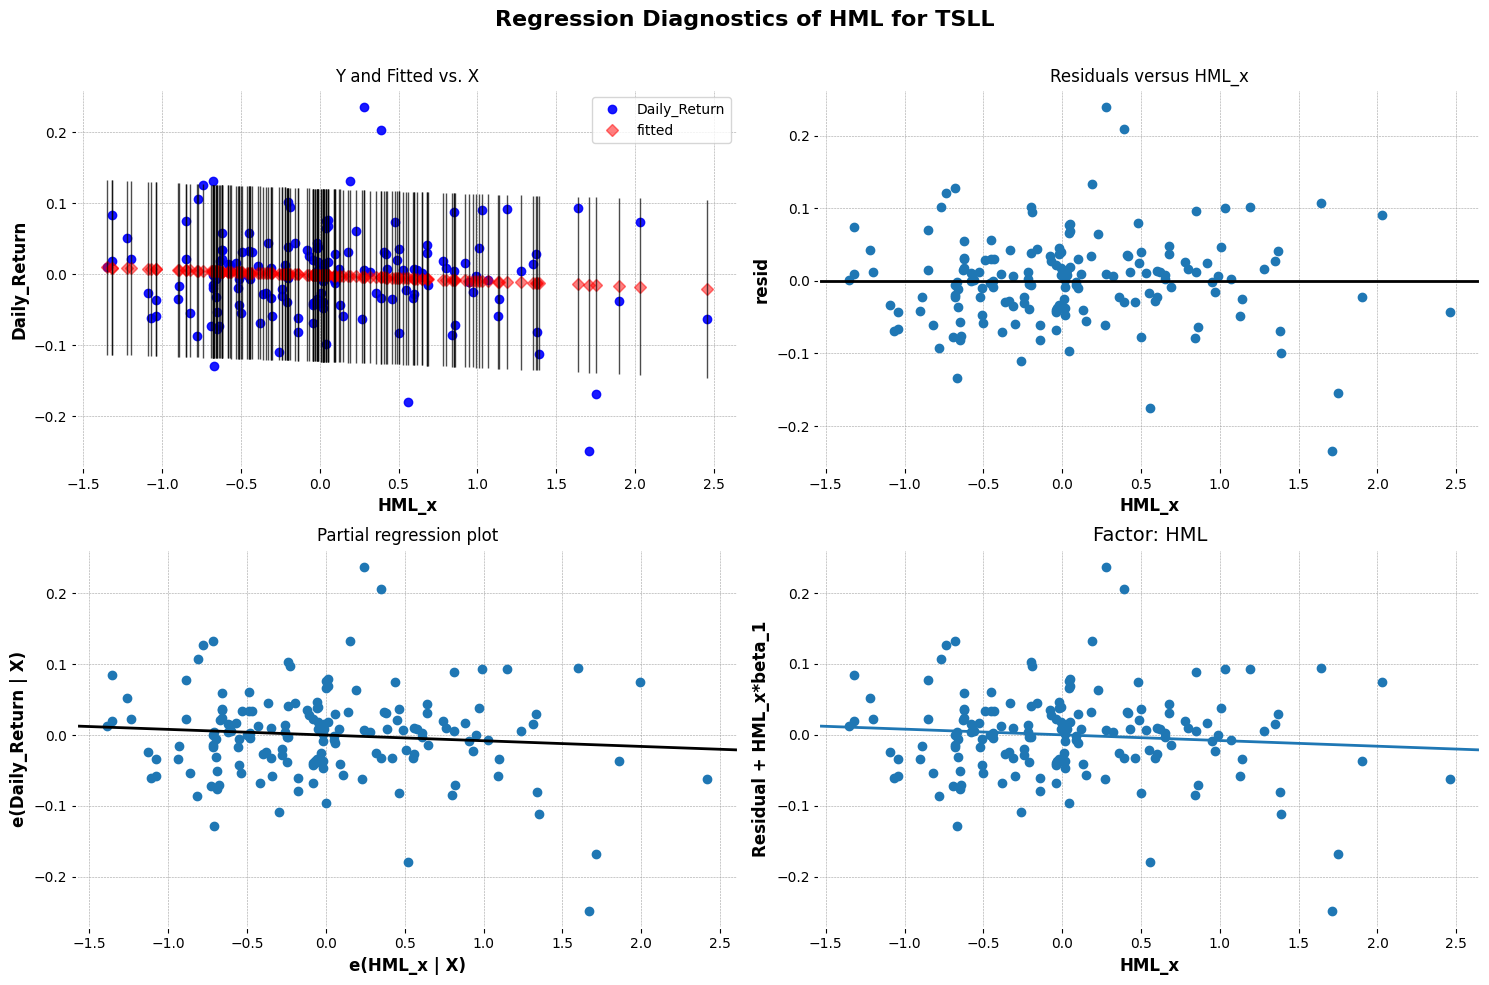

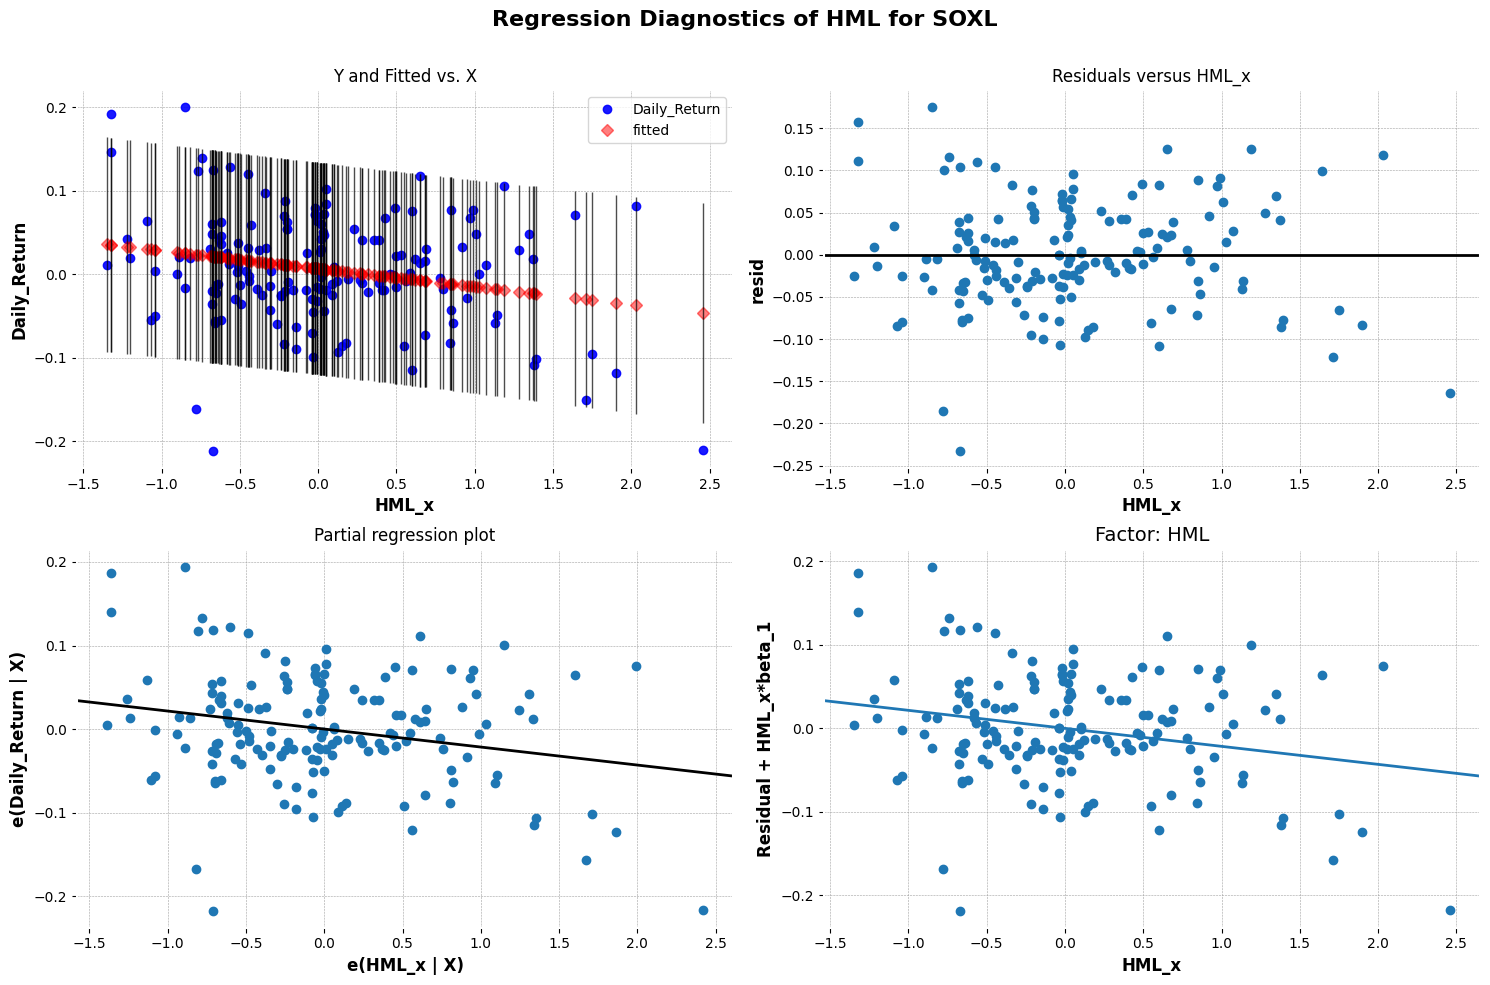

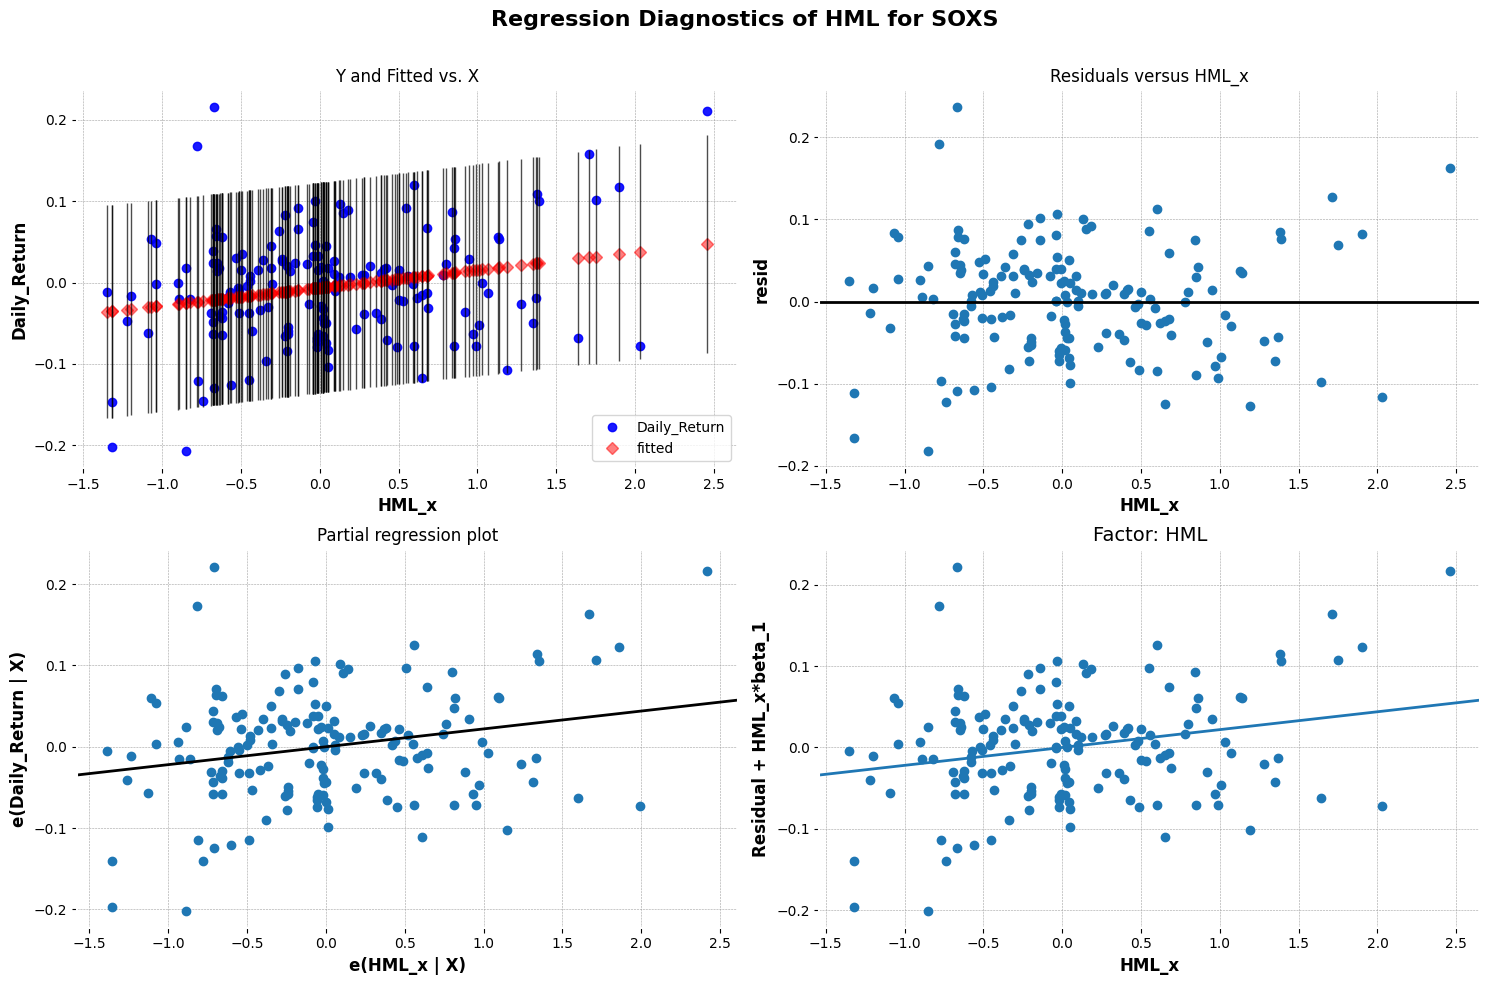

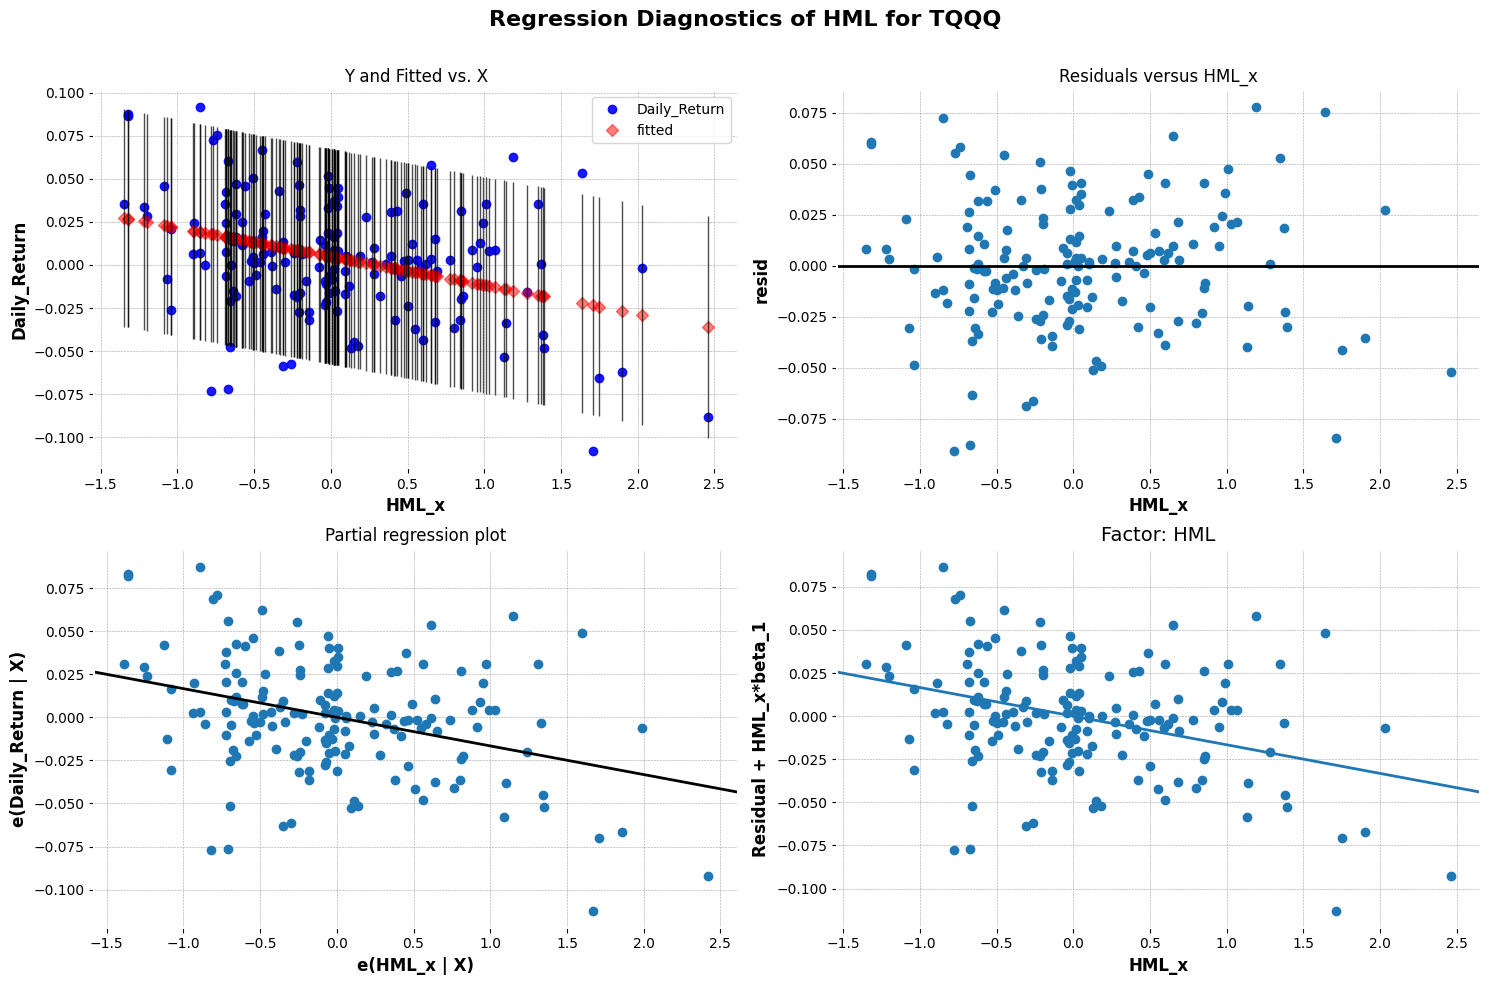

In [20]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get all tickers (tables) except 'etf_categories'
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories'")
tickers = [ticker[0] for ticker in cursor.fetchall()][:5]  # Get first 5 tickers

def plot_regression_results_HML(ticker):
    """Plot regression diagnostics for the specified ticker."""
    try:
        # Fetch data for the ticker
        query = f"SELECT Date, Daily_Return, HML_x FROM {ticker}"
        df = pd.read_sql_query(query, conn)
        
        # Ensure Date is datetime and set it as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Drop rows with NaN values in Daily_Return or HML
        df.dropna(subset=['Daily_Return', 'HML_x'], inplace=True)

        # Define dependent and independent variables
        X = sm.add_constant(df['HML_x'])  # Add a constant term for the intercept
        y = df['Daily_Return']

        # Fit the regression model
        model = sm.OLS(y, X).fit()

        # Plotting residuals vs HML
        fig = plt.figure(figsize=(15, 10))
        sm.graphics.plot_regress_exog(model, 'HML_x', fig=fig)
        plt.suptitle(f'Regression Diagnostics of HML for {ticker}', fontsize=16)
        plt.title(f'Factor: HML', fontsize=14)
    
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

# Process each ticker and plot regression results
for ticker in tickers:
    plot_regression_results_HML(ticker)


4.2) SMB

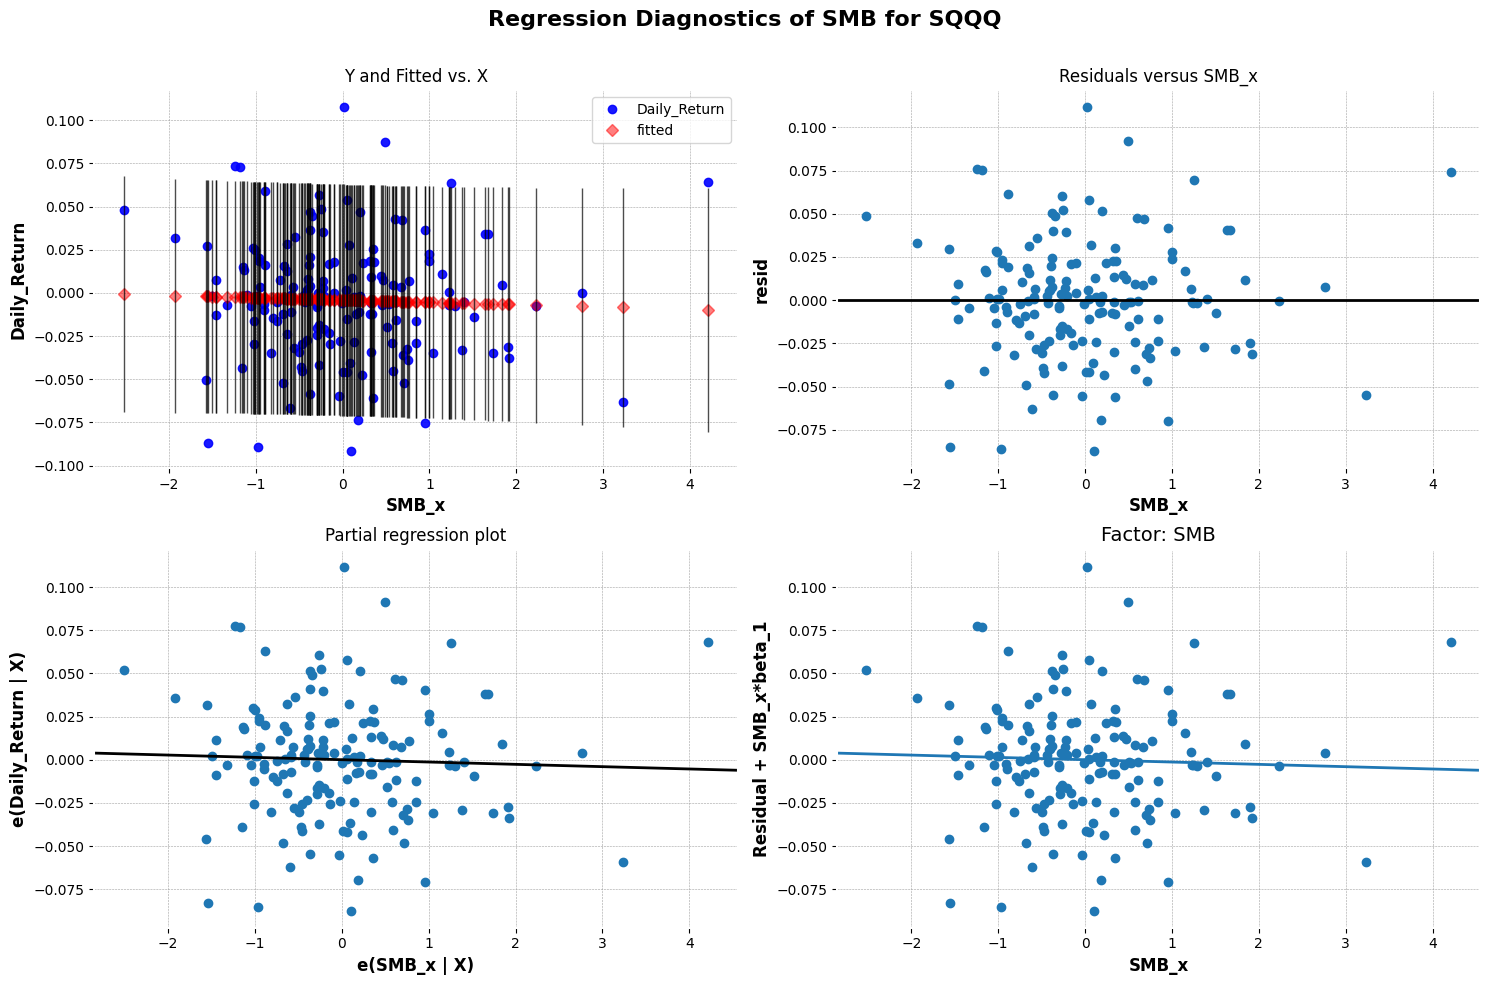

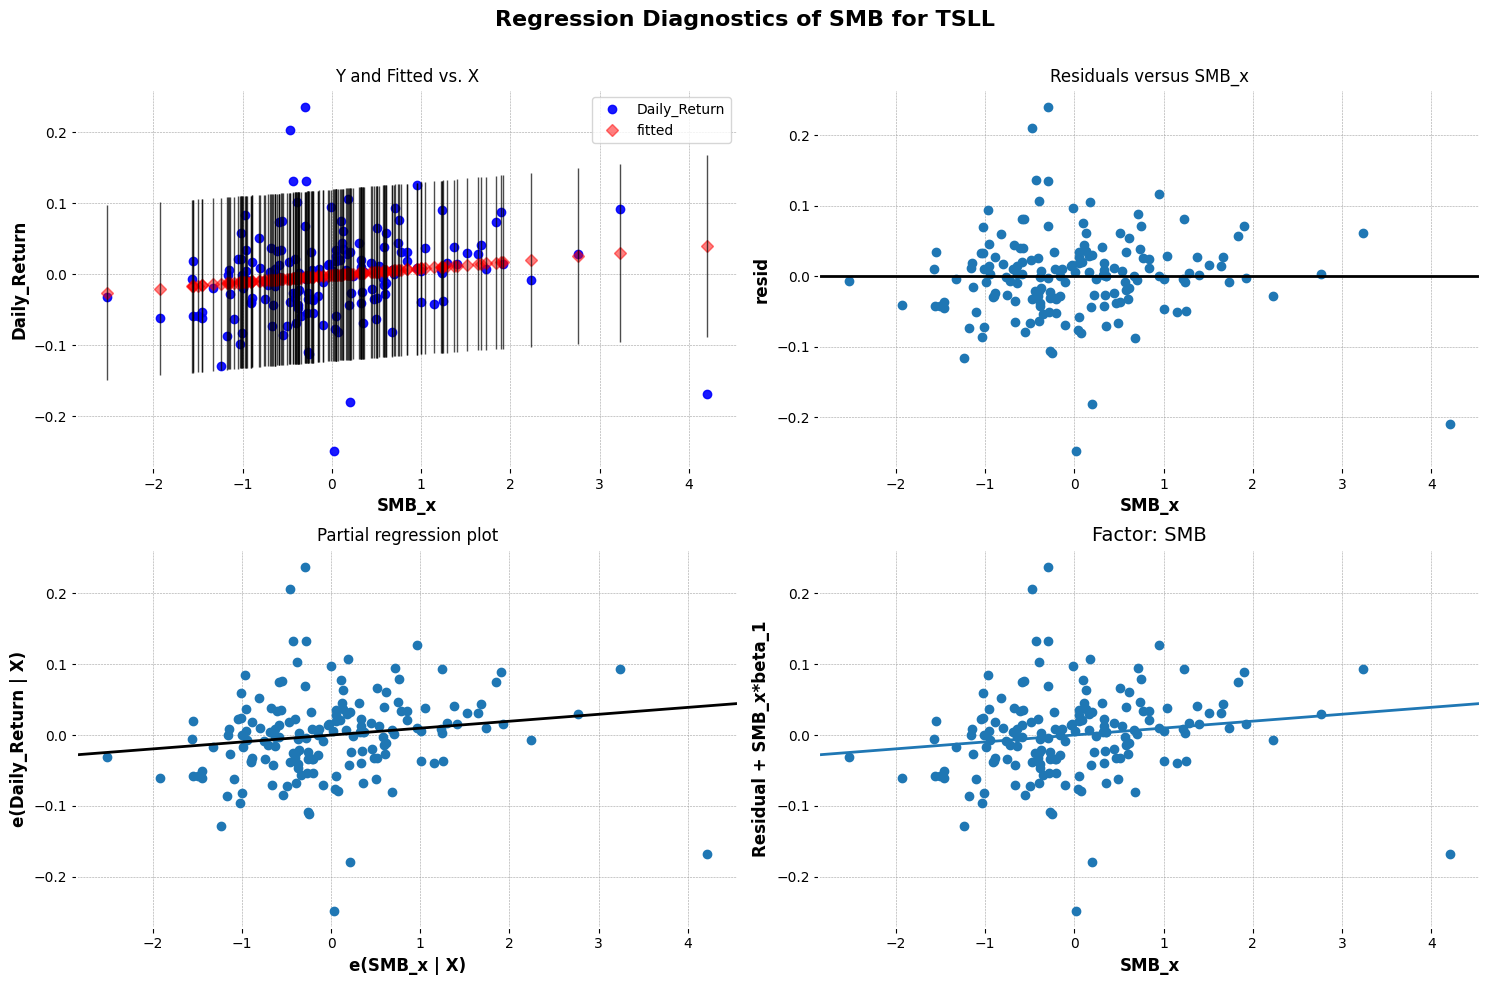

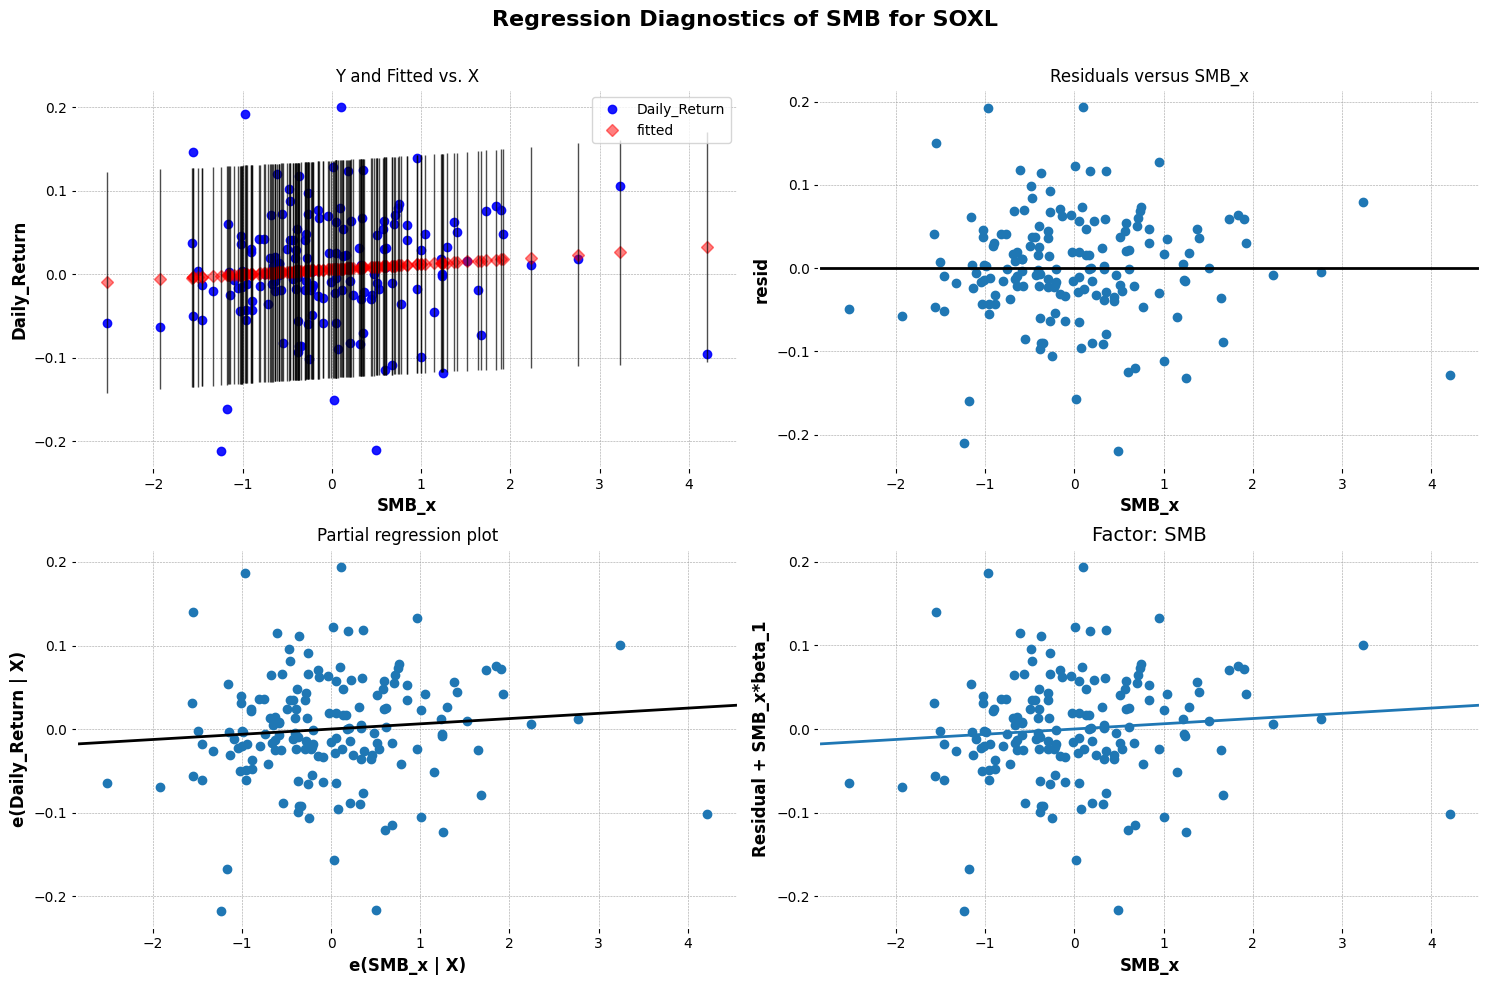

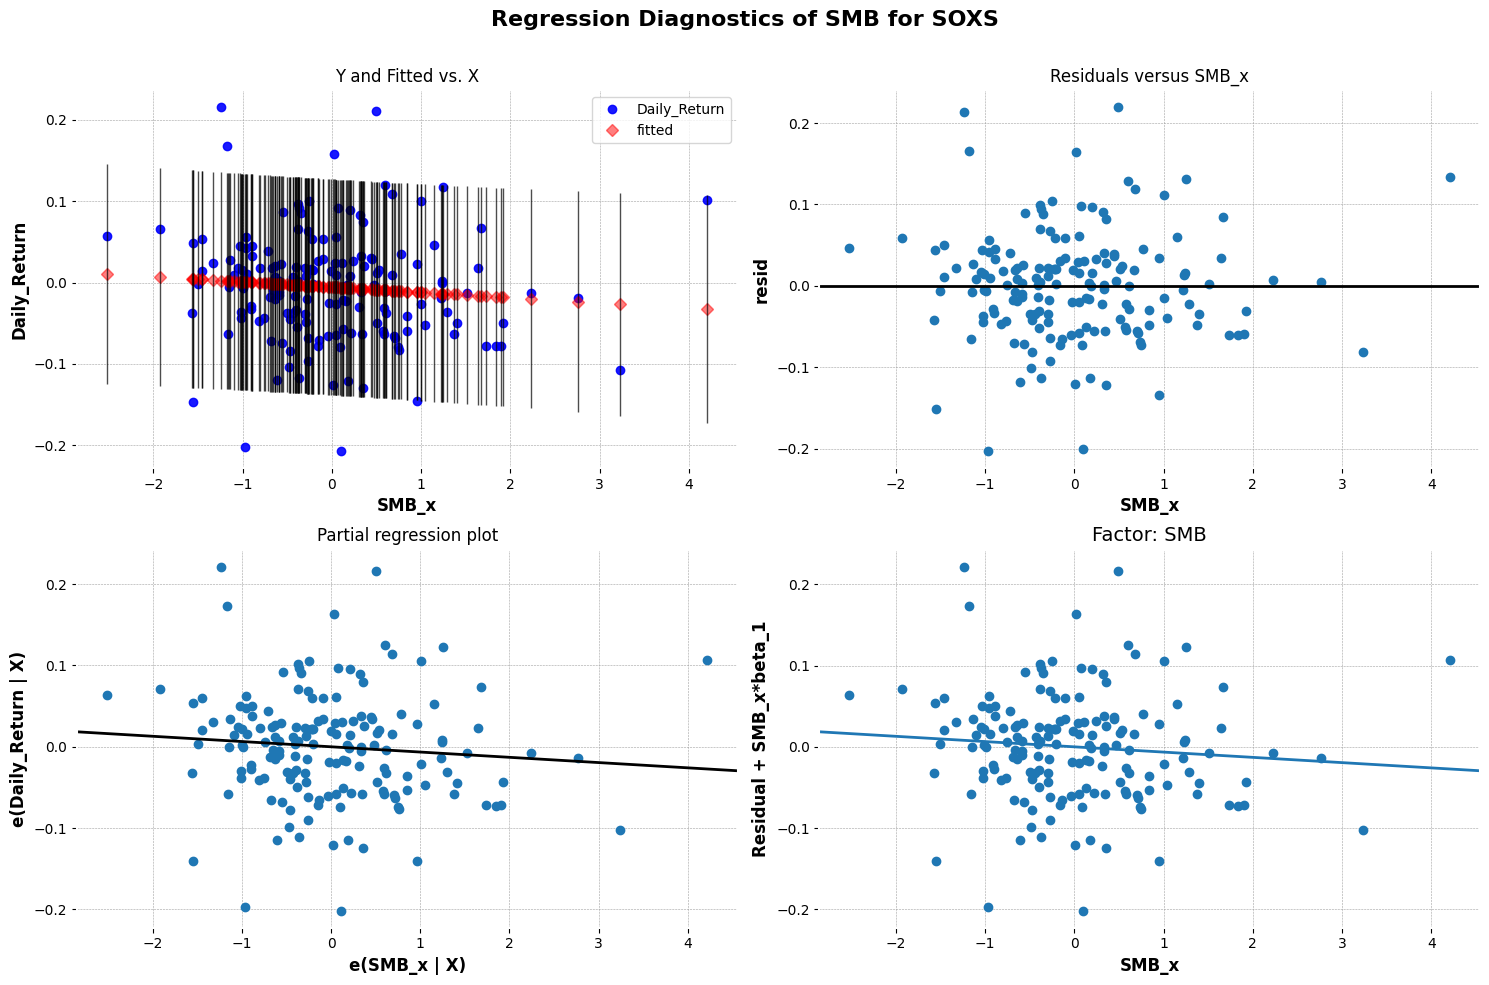

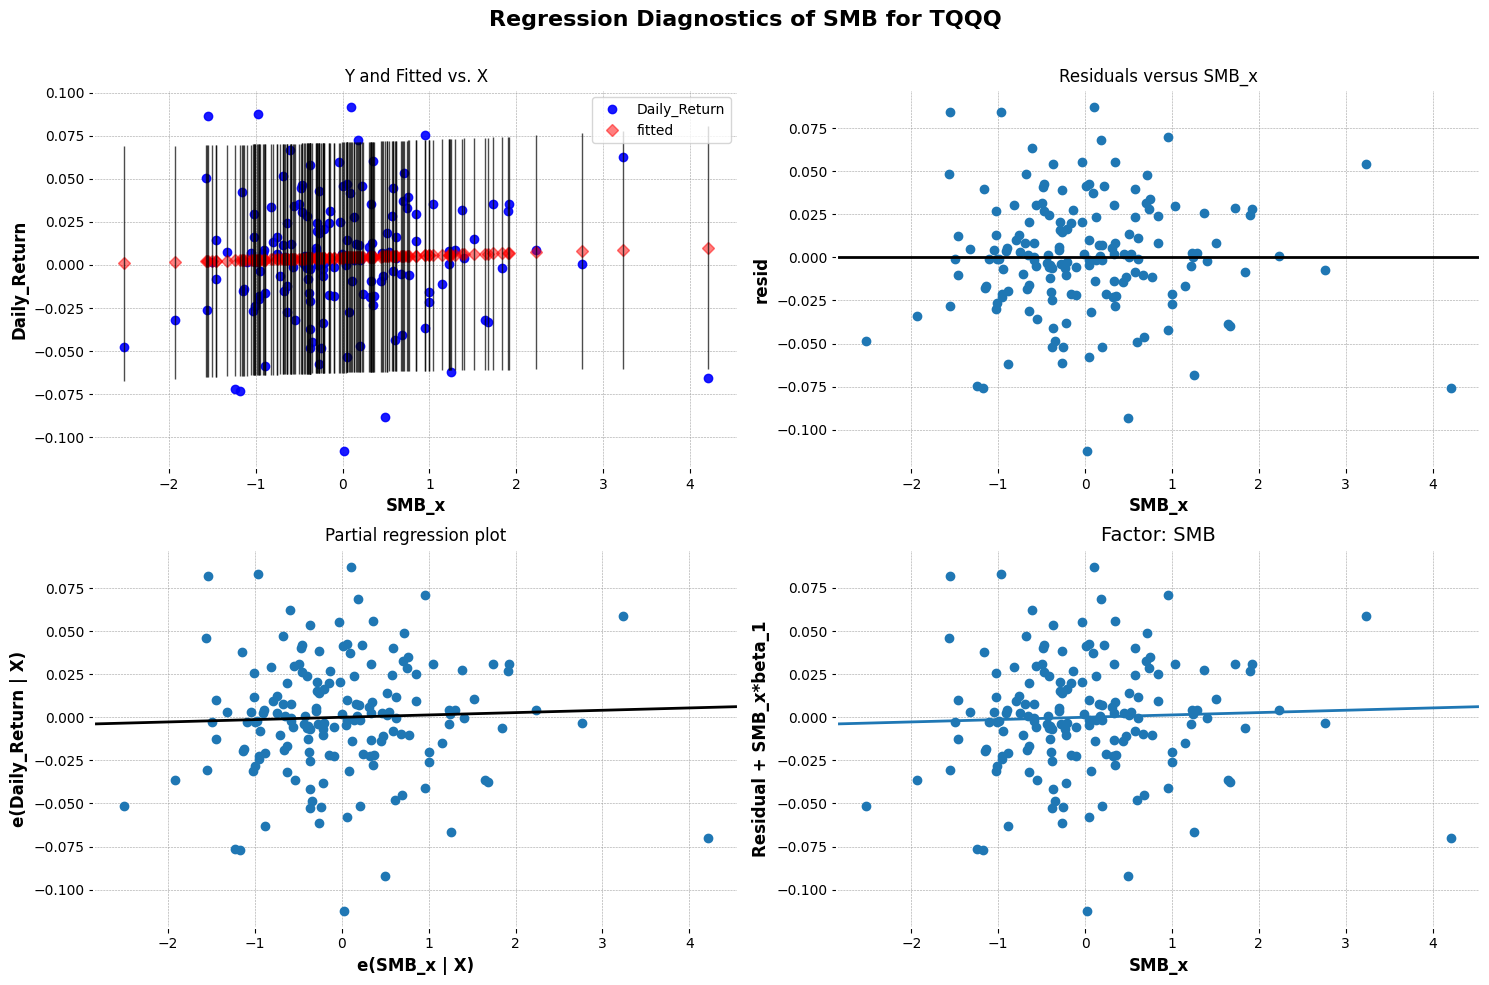

In [21]:
# Get db path
db_path = os.path.join(os.getcwd(), 'etf_data.db')
conn = sqlite3.connect(db_path)

# Get all tickers (tables) except 'etf_categories'
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'etf_categories'")
tickers = [ticker[0] for ticker in cursor.fetchall()][:5]  # Get first 5 tickers

def plot_regression_results_HML(ticker):
    """Plot regression diagnostics for the specified ticker."""
    try:
        # Fetch data for the ticker
        query = f"SELECT Date, Daily_Return, SMB_x FROM {ticker}"
        df = pd.read_sql_query(query, conn)
        
        # Ensure Date is datetime and set it as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Drop rows with NaN values in Daily_Return or HML
        df.dropna(subset=['Daily_Return', 'SMB_x'], inplace=True)

        # Define dependent and independent variables
        X = sm.add_constant(df['SMB_x'])  # Add a constant term for the intercept
        y = df['Daily_Return']

        # Fit the regression model
        model = sm.OLS(y, X).fit()

        # Plotting residuals vs HML
        fig = plt.figure(figsize=(15, 10))
        sm.graphics.plot_regress_exog(model, 'SMB_x', fig=fig)
        plt.suptitle(f'Regression Diagnostics of SMB for {ticker}', fontsize=16)
        plt.title(f'Factor: SMB', fontsize=14)
    
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

# Process each ticker and plot regression results
for ticker in tickers:
    plot_regression_results_HML(ticker)


Note: Same plots can be generated also for Mkt-RF, 'RMW' and 'CMA'

In [22]:
# Close the cursor and connection
cursor.close()
conn.close()